In [4]:
import numpy as np
import pandas as pd
import statsmodels
import scipy as sp
import scipy.io as sio
import seaborn as sns
import os
import warnings
from statistics import mean, stdev

from matplotlib import pyplot as plt
%matplotlib inline
from pathlib import Path
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from itertools import product
from nilearn.plotting import plot_connectome

# Load and Pre-Process Data

In [5]:
top_dir = Path("./")
data_dir = top_dir/"data/"
filenames = ['resultsROI_Subject'+str(f'{n:03}')+'_Condition001.mat' for n in range(1, 68)]
subj_list = [str(f'{n:03}') for n in range(1, 68)]

In [6]:
def read_in_matrices(subj_list, rois=246, data_dir=data_dir):
    all_fc_data = {}
            
    for subj in subj_list:
        # try to find this subject's matrix
        file = ['resultsROI_Subject' + str(f'{subj:03}') + '_Condition001.mat']
            
        # make sure there is one and only one file    
        if len(file) == 0:
            raise ValueError("No data found for subject {}".format(subj))
        if len(file) > 1:
            raise ValueError("More than one matrix found for subject {}!".format(subj))
        
        # read it in and make sure it's symmetric and has reasonable dimensions
        mat_contents = sio.loadmat(data_dir / file[0])
        tmp = np.array(mat_contents['Z'])[0:rois, 0:rois]

        assert tmp.shape[0]==tmp.shape[1]>1, "Matrix seems to have incorrect dimensions: {}".format(tmp.shape)
        
        # take just the upper triangle and store it in a dictionary
        all_fc_data[subj] = tmp[np.triu_indices_from(tmp, k=1)]
        
    # Convert dictionary into dataframe
    all_fc_data = pd.DataFrame.from_dict(all_fc_data, orient='index')
    
    return all_fc_data

In [7]:
all_fc_data = read_in_matrices(subj_list)

In [8]:
print(all_fc_data.shape)

all_fc_data.head()

(67, 30135)


,0,1,2,3,4,5,6,7,8,9,...,30125,30126,30127,30128,30129,30130,30131,30132,30133,30134
001,1.030025,0.009692,-0.152852,-0.022163,0.031680,0.128261,0.073554,0.144796,0.140742,0.593572,...,0.205569,0.680249,0.025802,0.529793,0.564839,0.191575,0.160984,0.130054,0.641528,0.402042
002,0.658572,0.194327,-0.080363,0.218516,-0.114567,0.283965,0.230442,0.341212,0.277316,0.541857,...,0.713951,0.821476,0.161248,0.545403,0.574097,0.300264,0.647610,-0.135975,0.293622,0.486704
003,0.783952,0.560778,0.211034,0.370513,0.055676,0.390137,0.240742,0.590637,0.290211,0.482062,...,0.262971,0.612376,-0.059597,0.446180,0.476171,0.135137,0.145007,-0.035566,0.110941,0.008360
004,0.995534,0.090738,0.079581,0.119594,-0.037282,0.353007,0.208717,0.544411,0.458788,0.485143,...,0.868844,0.938846,0.245369,0.587983,1.334884,0.187065,0.246784,0.262411,0.419086,0.673830
005,1.223704,0.172437,-0.243615,-0.121502,-0.110922,0.093052,0.080367,-0.106479,0.124017,0.419858,...,0.647836,0.787690,0.077996,0.564941,0.774018,0.088400,0.566844,0.143555,0.608932,0.296449


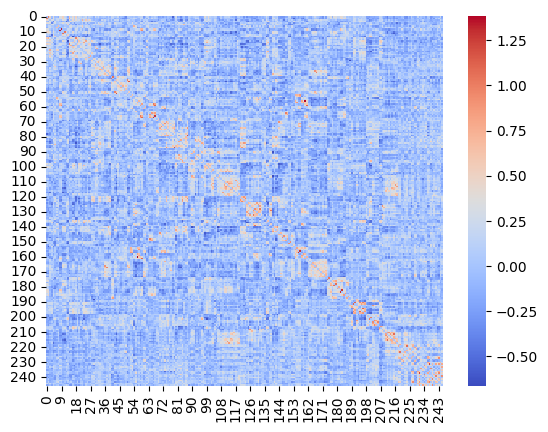

In [9]:
s = 42

sns.heatmap(sp.spatial.distance.squareform(all_fc_data.iloc[s, :]), cmap = 'coolwarm')
plt.show()

In [10]:
dyscalculic = [0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1]

# Create lists of indices for group == 0 and group == 1
group_TD_indices = [i for i, x in enumerate(dyscalculic) if x == 0]
group_DD_indices = [i for i, x in enumerate(dyscalculic) if x == 1]

# Modified CPM

In [11]:
# Helper function to calculate Cohen's d from t-value
def cohens_d_from_t(t_value, n1, n2):
    return t_value * np.sqrt((1/n1) + (1/n2))

# Main function for leave-two-out cross-validation
def leave_two_out_cv(data, labels, groupA_indices, groupB_indices, threshold=0.8, alpha=0.05):
    num_cols = data.shape[1] # to iterate through when doing ttests
    n1, n2 = len(groupA_indices), len(groupB_indices)
    accuracy_scores = []
    auc_scores = []

    # Dictionary with matrices storing t-val, p-val, and Cohen's d
    # nrow of each matrix is number of folds (n1*n2) and each column of matrix corresponds to each edge (upper triangle of input connectome data)
    extra_output = {
        "t": np.zeros((n1 * n2, num_cols)),
        "p": np.zeros((n1 * n2, num_cols)),
        "d": np.zeros((n1 * n2, num_cols)),
        "ids": np.zeros((n1 * n2, 2))
    }

    # Matrix to store which columns that pass Cohen's d threshold in each fold
    pass_matrix = np.zeros((n1 * n2, num_cols))
    
    fold = 0
    for idA, idB in product(groupA_indices, groupB_indices):
        print("Starting fold {} of {}".format(fold, pass_matrix.shape[0] - 1))

        # Leave one out from each group
        train_indices = np.delete(np.arange(data.shape[0]), [idA, idB])
        test_indices = [idA, idB]

        # Store IDs that correspond to each row in case needed later on
        extra_output['ids'][fold, :] = test_indices

        # Split data into two groups for t-tests
        groupA_train = data[np.setdiff1d(groupA_indices, [idA]), :]
        groupB_train = data[np.setdiff1d(groupB_indices, [idB]), :]
        
        # Perform t-tests and calculate Cohen's d for all columns
        passing_indices_pos = []
        passing_indices_neg = []

        for i in range(num_cols):
            t_stat, p_val = sp.stats.ttest_ind(groupA_train[:, i], groupB_train[:, i], equal_var=False)
            d = cohens_d_from_t(t_stat, n1, n2)

            extra_output['t'][fold, i] = t_stat
            extra_output['p'][fold, i] = p_val
            extra_output['d'][fold, i] = d
            
            # Track columns passing the threshold
            if d >= threshold and p_val < alpha:
                passing_indices_pos.append(i)
                pass_matrix[fold, i] = 1  # Cohen's d >= 0.8 and p < 0.05 (otherwise leave as 0)
            elif d <= -threshold and p_val < alpha:
                passing_indices_neg.append(i)
                pass_matrix[fold, i] = -1  # Cohen's d <= -0.8 and p < 0.05 (otherwise leave as 0)

        # Create new matrices with passing columns
        if passing_indices_pos:
            filtered_pos = data[:, passing_indices_pos]
            row_sum_pos = np.sum(filtered_pos[train_indices], axis=1)
        else:
            row_sum_pos = np.zeros(len(train_indices))  # No passing columns
        
        if passing_indices_neg:
            filtered_neg = data[:, passing_indices_neg]
            row_sum_neg = np.sum(filtered_neg[train_indices], axis=1)
        else:
            row_sum_neg = np.zeros(len(train_indices))  # No passing columns

        # Combine row sums as features for logistic regression
        design_matrix = np.vstack([row_sum_pos, row_sum_neg]).T
        
        # Logistic regression on the design matrix
        model = LogisticRegression()
        model.fit(design_matrix, labels[train_indices])

        # Test on the left-out samples
        test_pos_sum = np.sum(data[test_indices][:, passing_indices_pos], axis=1) if passing_indices_pos else np.zeros(2)
        test_neg_sum = np.sum(data[test_indices][:, passing_indices_neg], axis=1) if passing_indices_neg else np.zeros(2)
        X_test = np.vstack([test_pos_sum, test_neg_sum]).T
        y_test = labels[test_indices]

        # Predictions and probability estimates
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        # Calculate accuracy and AUC
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)

        accuracy_scores.append(accuracy)
        auc_scores.append(auc)

        fold += 1

    print("Calculations complete.")
    return accuracy_scores, auc_scores, pass_matrix, extra_output

In [132]:
# Mock data
np.random.seed(42)
mock_data1 = np.random.randn(30, 15)
mock_data2 = 50 + 5 * np.random.randn(37, 15)
mock_data = np.concatenate((mock_data1, mock_data2), axis=0)

labels = np.array([0] * 30 + [1] * 37)  # 0 for DD, 1 for TD

# Indices for the two groups
groupA_indices = np.arange(30)
groupB_indices = np.arange(30, 67)

# Apply the leave-two-out cross-validation
mock_accuracy_scores, mock_auc_scores, mock_pass_matrix, _ = leave_two_out_cv(mock_data, labels, groupA_indices, groupB_indices, threshold=0.2)

# Output mean accuracy and AUC across folds
mock_mean_accuracy = np.mean(mock_accuracy_scores)
mock_mean_auc = np.mean(mock_auc_scores)

# Calculate percentage of passing columns
mock_pass_percentages = np.mean(mock_pass_matrix != 0, axis=0) # Percentage of passing columns

mock_mean_accuracy, mock_mean_auc, mock_pass_percentages, mock_pass_matrix

Starting fold 0 of 1109
Starting fold 1 of 1109
Starting fold 2 of 1109
Starting fold 3 of 1109
Starting fold 4 of 1109
Starting fold 5 of 1109
Starting fold 6 of 1109
Starting fold 7 of 1109
Starting fold 8 of 1109
Starting fold 9 of 1109
Starting fold 10 of 1109
Starting fold 11 of 1109
Starting fold 12 of 1109
Starting fold 13 of 1109
Starting fold 14 of 1109
Starting fold 15 of 1109
Starting fold 16 of 1109
Starting fold 17 of 1109
Starting fold 18 of 1109
Starting fold 19 of 1109
Starting fold 20 of 1109
Starting fold 21 of 1109
Starting fold 22 of 1109
Starting fold 23 of 1109
Starting fold 24 of 1109
Starting fold 25 of 1109
Starting fold 26 of 1109
Starting fold 27 of 1109
Starting fold 28 of 1109
Starting fold 29 of 1109
Starting fold 30 of 1109
Starting fold 31 of 1109
Starting fold 32 of 1109
Starting fold 33 of 1109
Starting fold 34 of 1109
Starting fold 35 of 1109
Starting fold 36 of 1109
Starting fold 37 of 1109
Starting fold 38 of 1109
Starting fold 39 of 1109
Starting f

(np.float64(1.0),
 np.float64(1.0),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]))

In [13]:
# Apply the leave-two-out cross-validation
accuracy_scores, auc_scores, pass_matrix, extra_output = leave_two_out_cv(np.array(all_fc_data), np.array(dyscalculic), group_TD_indices, group_DD_indices)

Starting fold 0 of 1101
Starting fold 1 of 1101
Starting fold 2 of 1101
Starting fold 3 of 1101
Starting fold 4 of 1101
Starting fold 5 of 1101
Starting fold 6 of 1101
Starting fold 7 of 1101
Starting fold 8 of 1101
Starting fold 9 of 1101
Starting fold 10 of 1101
Starting fold 11 of 1101
Starting fold 12 of 1101
Starting fold 13 of 1101
Starting fold 14 of 1101
Starting fold 15 of 1101
Starting fold 16 of 1101
Starting fold 17 of 1101
Starting fold 18 of 1101
Starting fold 19 of 1101
Starting fold 20 of 1101
Starting fold 21 of 1101
Starting fold 22 of 1101
Starting fold 23 of 1101
Starting fold 24 of 1101
Starting fold 25 of 1101
Starting fold 26 of 1101
Starting fold 27 of 1101
Starting fold 28 of 1101
Starting fold 29 of 1101
Starting fold 30 of 1101
Starting fold 31 of 1101
Starting fold 32 of 1101
Starting fold 33 of 1101
Starting fold 34 of 1101
Starting fold 35 of 1101
Starting fold 36 of 1101
Starting fold 37 of 1101
Starting fold 38 of 1101
Starting fold 39 of 1101
Starting f

In [83]:
# Output mean accuracy and AUC across folds
mean_accuracy = np.mean(accuracy_scores)
mean_auc = np.mean(auc_scores)

# Calculate percentage of passing columns
pass_percentages = np.mean(pass_matrix != 0, axis=0) # Percentage of passing columns

[mean_accuracy, mean_auc]

[np.float64(0.4986388384754991), np.float64(0.5081669691470054)]

# Visualization

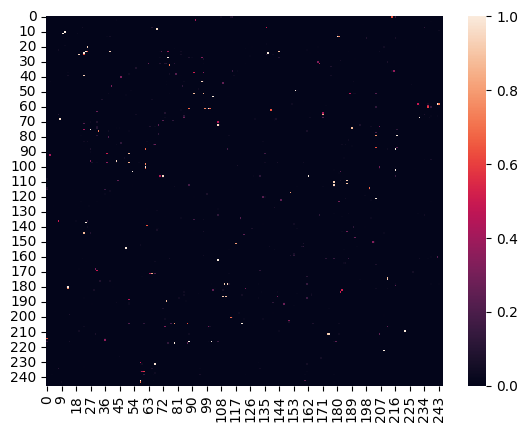

In [80]:
# pass_percentages_square = sp.spatial.distance.squareform(pass_percentages)

sns.heatmap(pass_percentages_square, vmin=0, vmax=1)
plt.show()

In [137]:
pass_percentages_square[np.triu_indices_from(pass_percentages_square, k=1)].shape

(30135,)

In [22]:
brain_coords = pd.read_csv("brainnetome_coords.csv", index_col="index")
brain_xyz = brain_coords.iloc[:, 1:4]

In [19]:
def plot_consistent_edges(pass_matrix, direction, thresh=0.75, color='gray'):

    if direction == 1:
        edge_frac = np.mean(pass_matrix == 1, axis=0)
        print("For positive t-values, where the connectivity was greater in TA than DD, {} edges were selected in at least {}% of folds.".format((edge_frac >= thresh).sum(), thresh * 100))
    elif direction == -1:
        edge_frac = np.mean(pass_matrix == -1, axis=0)
        print("For negative t-values, where the connectivity was greater in DD than TA, {} edges were selected in at least {}% of folds.".format((edge_frac >= thresh).sum(), thresh * 100))

    edge_frac_square = sp.spatial.distance.squareform(edge_frac)
    
    node_mask = np.amax(edge_frac_square, axis=0) >= thresh # find nodes that have at least one edge that passes the threshold
    node_size = edge_frac_square.sum(axis=0) * node_mask * 20 # size nodes based on how many suprathreshold edges they have

    plot_connectome(adjacency_matrix=edge_frac_square, edge_threshold=thresh,
                    node_color = color,
                    node_coords = brain_xyz, node_size=node_size,
                    display_mode = 'lzry',
                    edge_kwargs = {"linewidth": 1, 'color': color})


For positive t-values, where the connectivity was greater in TA than DD, 7 edges were selected in at least 75.0% of folds.


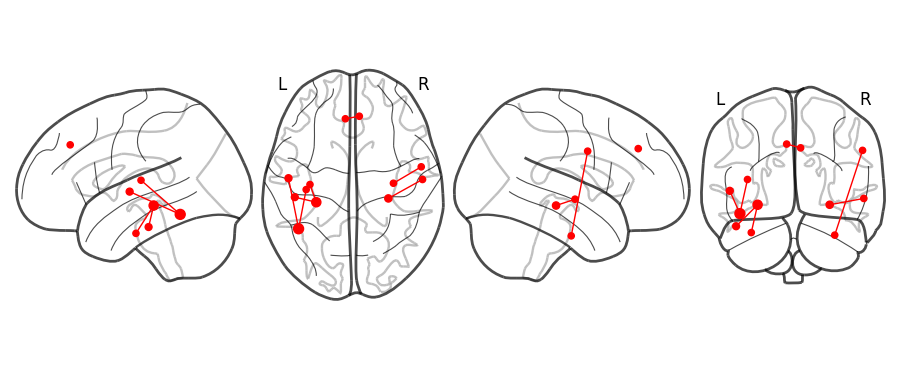

In [84]:
plot_consistent_edges(pass_matrix, 1, thresh=0.75, color='red')

For negative t-values, where the connectivity was greater in DD than TA, 28 edges were selected in at least 75.0% of folds.


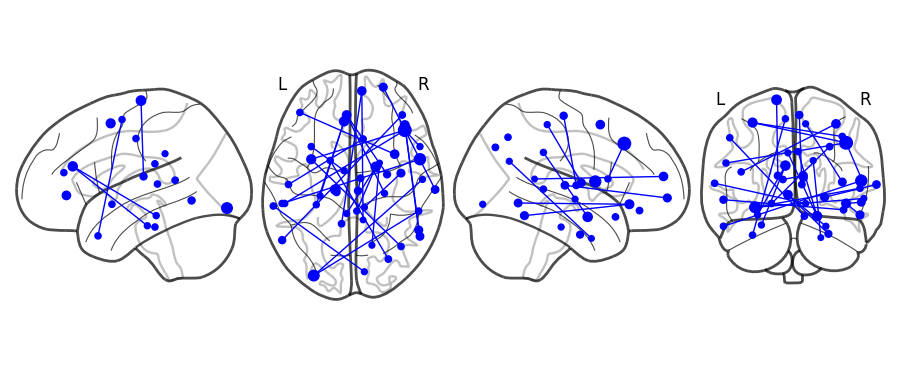

In [85]:
plot_consistent_edges(pass_matrix, -1, thresh=0.75, color='blue')

# Tabulated Results

In [73]:
brain_df = pd.read_csv("brainnetome_coords.csv")
brain_df.insert(0, 'roi_index', np.array(range(0, 246)))
brain_df = brain_df.loc[:, ['roi_index', 'name', 'x.mni', 'y.mni', 'z.mni', 'gyrus.full', 'subregion.full']]

def print_edge_df(brain_df, pass_matrix, direction, threshold = 0.75):
    pass_square = sp.spatial.distance.squareform(np.mean(pass_matrix == direction, axis=0))
    all_coords = zip(np.where(pass_square > threshold)[0], np.where(pass_square > threshold)[1])
    unique_coordinates = {tuple(sorted(pair)) for pair in all_coords}

    l_indices = np.array(pd.DataFrame(unique_coordinates, columns=['x', 'y'])['x'])
    r_indices = np.array(pd.DataFrame(unique_coordinates, columns=['x', 'y'])['y'])

    l_df = brain_df.iloc[l_indices,:].reset_index(drop=True)
    r_df = brain_df.iloc[r_indices,:].reset_index(drop=True)

    output = pd.concat([l_df, r_df], axis=1, keys=['node1', 'node2'])

    output.insert(0, 'percentage', np.round(np.array(pass_percentages_square[l_indices, r_indices]), 4))

    return output

In [115]:
# For positive t-values, where the connectivity was greater in TA than DD
print_edge_df(brain_df = brain_df, pass_matrix = pass_matrix, direction = 1, threshold = 0.75)

percentage   node1                                                        \
             pyIndex       name x.mni y.mni z.mni               gyrus.full   
0     1.0000      10  SFG_L_7_6    -5    36    38   Superior Frontal Gyrus   
1     1.0000      88  ITG_L_7_1   -45   -26   -27  Inferior Temporal Gyrus   
2     1.0000     102  FuG_L_3_1   -33   -16   -32           Fusiform Gyrus   
3     1.0000      53  PrG_R_6_1    55    -2    33         Precentral Gyrus   
4     0.9519      72  STG_L_6_3   -50   -11     1  Superior Temporal Gyrus   
5     0.9936      79  STG_R_6_6    56   -12    -5  Superior Temporal Gyrus   
6     1.0000     106  FuG_L_3_3   -42   -51   -17           Fusiform Gyrus   

                                   node2                                \
                  subregion.full pyIndex        name x.mni y.mni z.mni   
0                  medial area 9      11   SFG_R_7_6     6    38    35   
1   intermediate ventral area 20     216  Hipp_L_2_2   -28   -30   -10   
2          rostroventral area 20     216  Hipp_L_2_2   -28   -30   -10   
3  area 4 (head and face region)     103   FuG_R_3_1    33   -15   -34   
4                            NaN     106   FuG_L_3_3   -42   -51   -17   
5                rostral area 22     217  Hipp_R_2_2    29   -27   -10   
6          lateroventral area 37     162   INS_L_6_1   -36   -20    10   

                                                  
               gyrus.full         subregion.full  
0  Superior Frontal Gyrus          medial area 9  
1             Hippocampus     caudal hippocampus  
2             Hippocampus     caudal hippocampus  
3          Fusiform Gyrus  rostroventral area 20  
4          Fusiform Gyrus  lateroventral area 37  
5             Hippocampus     caudal hippocampus  
6           Insular Gyrus   hypergranular insula

In [116]:
# For negative t-values, where the connectivity was greater in DD than TA
print_edge_df(brain_df = brain_df, pass_matrix = pass_matrix, direction = -1, threshold = 0.75)

percentage   node1                                \
              pyIndex        name x.mni y.mni z.mni   
0      0.7759      79   STG_R_6_6    56   -12    -5   
1      1.0000      58   PrG_L_6_4   -13   -20    73   
2      1.0000      49   OrG_R_6_5     9    20   -19   
3      1.0000     209  LOcC_R_2_2    29   -75    36   
4      0.8031     117   PhG_R_6_5    22     1   -36   
5      0.8784      23   MFG_R_7_5    42    27    39   
6      0.8358      65   PCL_R_2_1    10   -34    54   
7      0.8820      74   STG_L_6_4   -62   -33     7   
8      0.9437     175    CG_R_7_1     4   -37    32   
9      0.9274     110   PhG_L_6_2   -25   -25   -26   
10     1.0000      61   PrG_R_6_5    54     4     9   
11     0.9201     109   PhG_R_6_1    28    -8   -33   
12     0.8929     111   PhG_R_6_2    26   -23   -27   
13     0.9365      20   MFG_L_7_4   -41    41    16   
14     0.8902     174    CG_L_7_1    -4   -39    31   
15     1.0000      23   MFG_R_7_5    42    27    39   
16     0.9483     112   PhG_L_6_3   -28   -32   -18   
17     0.7523      13   SFG_R_7_7     8    58    13   
18     0.9328      23   MFG_R_7_5    42    27    39   
19     0.8766      51   OrG_R_6_6    42    31    -9   
20     0.9873      67   PCL_R_2_2     5   -21    61   
21     0.9483      43   OrG_R_6_2    40    39   -14   
22     0.8403      51   OrG_R_6_6    42    31    -9   
23     0.9682       8   SFG_L_7_5    -6    -5    58   
24     1.0000      27   MFG_R_7_7    25    61    -4   
25     1.0000      13   SFG_R_7_7     8    58    13   
26     0.9991      24   MFG_L_7_6   -32     4    55   
27     1.0000     121  pSTS_R_2_1    53   -37     3   

                                        \
                            gyrus.full   
0              Superior Temporal Gyrus   
1                     Precentral Gyrus   
2                        Orbital Gyrus   
3             lateral Occipital Cortex   
4                Parahippocampal Gyrus   
5                 Middle Frontal Gyrus   
6                   Paracentral Lobule   
7              Superior Temporal Gyrus   
8                      Cingulate Gyrus   
9                Parahippocampal Gyrus   
10                    Precentral Gyrus   
11               Parahippocampal Gyrus   
12               Parahippocampal Gyrus   
13                Middle Frontal Gyrus   
14                     Cingulate Gyrus   
15                Middle Frontal Gyrus   
16               Parahippocampal Gyrus   
17              Superior Frontal Gyrus   
18                Middle Frontal Gyrus   
19                       Orbital Gyrus   
20                  Paracentral Lobule   
21                       Orbital Gyrus   
22                       Orbital Gyrus   
23              Superior Frontal Gyrus   
24                Middle Frontal Gyrus   
25              Superior Frontal Gyrus   
26                Middle Frontal Gyrus   
27  posterior Superior Temporal Sulcus   

                                                        node2               \
                                       subregion.full pyIndex         name   
0                                     rostral area 22     204   LOcC_L_4_4   
1                               area 4 (trunk region)     242    Tha_L_8_7   
2                                             area 13     154    PoG_L_4_1   
3                    lateral superior occipital gyrus     222     BG_L_6_3   
4         area TI (temporal agranular insular cortex)     151   PCun_R_4_3   
5                                ventrolateral area 8     144    IPL_L_6_6   
6                       area1/2/3 (lower limb region)     171    INS_R_6_5   
7                                      caudal area 22     189  MVOcC_R_5_1   
8                                      dorsal area 23     211   Amyg_R_2_1   
9                                   caudal area 35/36     178     CG_L_7_3   
10                  area 4 (tongue and larynx region)     100    ITG_L_7_7   
11                                 rostral area 35/36     186     CG_L_7_7   